# Imputing Missingness in FreeSurfer Outputs (IMFO)
### **Shaina Sta. Cruz<sup>1</sup> and Farshid Sepehrband<sup>2</sup>**,  
*1. California State University, Fullerton, CA, USA*  
*2. Laboratory of Neuro Imaging, USC Mark and Mary Stevens Neuroimaging and Informatics Institute, Keck School of Medicine of USC, University of Southern California, Los Angeles, CA, USA*  

**June 29 2017**  
shainasta.cruz@gmail.com  
farshid.sepehrband@loni.usc.edu  

## Preparing the right data for the Shaina 
This notebook shows how to read FreeSurfer's output, prepare it for statsitcal analysis and keep a subset of interest.   

Here, we focus on FreeSurfer's derived measures relating **cortical thickness**, **volume** and **surface area**.  

We also use only FreeSurfer outputs of the **Desikan-Kiliany atlas**. Info about this atlas can be found here:   
http://www.sciencedirect.com/science/article/pii/S1053811906000437#bib21

## Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import pandas as pd 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
## Move to the parent directory (i.e., ".../IMFO" rather than ".../IMFO/bin")
myDir = os.path.abspath('..')
os.chdir(myDir)
sys.path.append('lib')

## input the main csv file

In [3]:
dataset = pd.read_csv('data/pnc_06262017.csv')
# dataset has extra quotation mark in the column names, so clean with:
dataset.columns = dataset.columns.str.replace('\'',"")

**Divide the DataFrame into:**
* neuroimaging data (FreeSurfer's output)
* confounds (Age, Race, ... )
* phenotype of interest (here gender)

In [4]:
icv_name = [col for col in list(dataset) if 'EstimatedTotalIntraCranialVol:N:volume' in col][0]
temp = [col for col in list(dataset) if col.startswith('FreeSurfer')]
temp.remove(icv_name)
nimg = dataset[temp]

temp = [col for col in list(dataset) if 'FreeSurfer' not in col]
temp.remove('Gender')
conf = dataset[temp]
conf = pd.concat([conf, dataset[icv_name]],axis=1)
conf.rename(columns = {icv_name:'ICV'}, inplace = True)
print(conf.describe())

pheno = dataset['Gender']

              Age          IQ       Race           ICV
count  997.000000  955.000000  997.00000  9.700000e+02
mean   175.722166  102.064921    0.45336  1.520268e+06
std     41.328371   15.477040    0.49807  1.706585e+05
min     99.000000   68.000000    0.00000  8.802730e+05
25%    140.000000   92.000000    0.00000  1.407098e+06
50%    177.000000  100.000000    0.00000  1.523210e+06
75%    210.000000  111.000000    1.00000  1.641225e+06
max    271.000000  145.000000    1.00000  1.986020e+06


**Note** that IQ include missing data (count = 955). To keep as many subject as possible, we remove the IQ info from this study. 

In [6]:
conf.drop('IQ',axis=1,inplace=True)
print(conf.describe())

              Age       Race           ICV
count  997.000000  997.00000  9.700000e+02
mean   175.722166    0.45336  1.520268e+06
std     41.328371    0.49807  1.706585e+05
min     99.000000    0.00000  8.802730e+05
25%    140.000000    0.00000  1.407098e+06
50%    177.000000    0.00000  1.523210e+06
75%    210.000000    1.00000  1.641225e+06
max    271.000000    1.00000  1.986020e+06


## Create a subset of the DataFram
This is based on the atlas and neuroanatomical features of interest

In [7]:
from DataEng import ParamLister
params = ['volume','thickness','area']
atlas_temp = ['FS_aparc_aseg'] 
# see help document of "ParamLister" function for all the possible options
# "ParamLister" outputs a list of desired features, plus an extension (e.g. VAT) for the name of outputs file
param_list, outParamName = ParamLister(params,atlas_temp,nimg)
New = pd.concat([nimg.loc[:,param_list],conf,pheno],axis=1)

208 neuroanatomical feature will be extraceted!


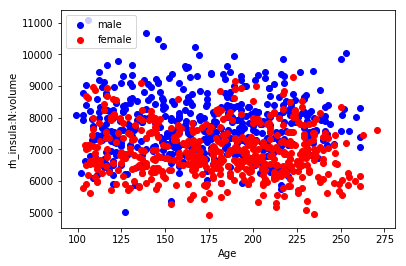

In [8]:
# take a look at a given neuroanatomical feature 
neuro = 'rh_insula:N:volume'
temp = [col for col in list(dataset) if neuro in col]

for i in 0,1:
    x = dataset.loc[dataset['Gender']==i,'Age']
    y = dataset.loc[dataset['Gender']==i,temp]
    plt.scatter(x,y,color='red' if i==1 else 'blue',label='female' if i==1 else 'male')

plt.legend(loc='upper left')
plt.xlabel('Age')
plt.ylabel(neuro)
plt.show()

## Ouput the modified DataFrame

In [8]:
New.to_csv('data/pnc_'+outParamName+'_'+datetime.datetime.now().strftime('%m%d%Y')+'.csv')